# Loan Approval Prediction & Credit Risk Analysis

**Role-play:** Retail Credit Risk Analytics — personal loan underwriting.

**Goal:** (1) understand drivers of approval decisions, (2) build an explainable model to estimate approval probability, and (3) propose a business-friendly decision threshold that balances growth and risk.

Dataset file: `../data/Loan.csv`  
Target: `LoanApproved` (1 = Approved, 0 = Declined)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, precision_recall_curve,
    precision_score, recall_score, f1_score
)

from sklearn.inspection import PartialDependenceDisplay

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 200)

In [2]:
# Load
df = pd.read_csv("../data/Loan.csv")

df.head()

,ApplicationDate,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,CreditCardUtilizationRate,NumberOfOpenCreditLines,NumberOfCreditInquiries,DebtToIncomeRatio,BankruptcyHistory,LoanPurpose,PreviousLoanDefaults,PaymentHistory,LengthOfCreditHistory,SavingsAccountBalance,CheckingAccountBalance,TotalAssets,TotalLiabilities,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,2018-01-01,45,39948,617,Employed,Master,22,13152,48,Married,2,Own,183,0.354418,1,2,0.358336,0,Home,0,29,9,7632,1202,146111,19183,3329.000000,0.724972,11,126928,0.199652,0.227590,419.805992,0.181077,0,49.0
1,2018-01-02,38,39709,628,Employed,Associate,15,26045,48,Single,1,Mortgage,496,0.087827,5,3,0.330274,0,Debt Consolidation,0,21,9,4627,3460,53204,9595,3309.083333,0.935132,3,43609,0.207045,0.201077,794.054238,0.389852,0,52.0
2,2018-01-03,47,40724,570,Employed,Bachelor,26,17627,36,Married,2,Rent,902,0.137414,2,0,0.244729,0,Education,0,20,22,886,895,25176,128874,3393.666667,0.872241,6,5205,0.217627,0.212548,666.406688,0.462157,0,52.0
3,2018-01-04,58,69084,545,Employed,High School,34,37898,96,Single,1,Mortgage,755,0.267587,2,1,0.436244,0,Home,0,27,10,1675,1217,104822,5370,5757.000000,0.896155,5,99452,0.300398,0.300911,1047.506980,0.313098,0,54.0
4,2018-01-05,37,103264,594,Employed,Associate,17,9184,36,Married,1,Mortgage,274,0.320535,0,0,0.078884,0,Debt Consolidation,0,26,27,1555,4981,244305,17286,8605.333333,0.941369,5,227019,0.197184,0.175990,330.179140,0.070210,1,36.0


## 1) Data Understanding & Cleaning

### What we check (bank-style):
- Schema & data types (including date parsing)
- Missingness, duplicates
- Range validation (age, credit score, ratios)
- Inconsistencies (e.g., negative balances, impossible values)

> Note: This dataset appears *synthetic* and very clean. In real underwriting data, expect missing values, reporting delays, and “derived” fields that can cause **label leakage** if they’re computed after a decision.

In [3]:
# Basic shape & types
print("Rows, Cols:", df.shape)
df.dtypes

Rows, Cols: (20000, 36)


ApplicationDate                object
Age                             int64
AnnualIncome                    int64
CreditScore                     int64
EmploymentStatus               object
EducationLevel                 object
Experience                      int64
LoanAmount                      int64
LoanDuration                    int64
MaritalStatus                  object
NumberOfDependents              int64
HomeOwnershipStatus            object
MonthlyDebtPayments             int64
CreditCardUtilizationRate     float64
NumberOfOpenCreditLines         int64
NumberOfCreditInquiries         int64
DebtToIncomeRatio             float64
BankruptcyHistory               int64
LoanPurpose                    object
PreviousLoanDefaults            int64
PaymentHistory                  int64
LengthOfCreditHistory           int64
SavingsAccountBalance           int64
CheckingAccountBalance          int64
TotalAssets                     int64
TotalLiabilities                int64
MonthlyIncom

In [4]:
# Parse dates + quick quality checks
df["ApplicationDate"] = pd.to_datetime(df["ApplicationDate"], errors="coerce")

dup_cnt = df.duplicated().sum()
missing = df.isna().mean().sort_values(ascending=False)

print("Duplicate rows:", dup_cnt)
missing.head(10)

Duplicate rows: 0


ApplicationDate               0.0
Age                           0.0
PaymentHistory                0.0
LengthOfCreditHistory         0.0
SavingsAccountBalance         0.0
CheckingAccountBalance        0.0
TotalAssets                   0.0
TotalLiabilities              0.0
MonthlyIncome                 0.0
UtilityBillsPaymentHistory    0.0
dtype: float64

In [5]:
# Range checks for a few high-signal fields
checks = {
    "Age": (df["Age"].min(), df["Age"].max()),
    "CreditScore": (df["CreditScore"].min(), df["CreditScore"].max()),
    "DebtToIncomeRatio": (df["DebtToIncomeRatio"].min(), df["DebtToIncomeRatio"].max()),
    "TotalDebtToIncomeRatio": (df["TotalDebtToIncomeRatio"].min(), df["TotalDebtToIncomeRatio"].max()),
    "RiskScore": (df["RiskScore"].min(), df["RiskScore"].max()),
}

checks

{'Age': (np.int64(18), np.int64(80)),
 'CreditScore': (np.int64(343), np.int64(712)),
 'DebtToIncomeRatio': (np.float64(0.0017200290084425),
  np.float64(0.9022526895282088)),
 'TotalDebtToIncomeRatio': (np.float64(0.0160432112095298),
  np.float64(4.647656816403158)),
 'RiskScore': (np.float64(28.8), np.float64(84.0))}

### Minimal feature engineering
We convert the application date into:
- `AppYear`, `AppMonth`, `AppDayOfWeek`

…and then drop the raw timestamp (avoid overfitting to date formatting and keep features numeric-friendly).

In [6]:
df_fe = df.copy()
df_fe["AppYear"] = df_fe["ApplicationDate"].dt.year
df_fe["AppMonth"] = df_fe["ApplicationDate"].dt.month
df_fe["AppDayOfWeek"] = df_fe["ApplicationDate"].dt.dayofweek
df_fe = df_fe.drop(columns=["ApplicationDate"])

target = "LoanApproved"
X = df_fe.drop(columns=[target])
y = df_fe[target]

cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

print("Categorical:", cat_cols)
print("Numeric:", len(num_cols), "features")

Categorical: ['EmploymentStatus', 'EducationLevel', 'MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose']
Numeric: 32 features


## 2) Exploratory Data Analysis (EDA)

We focus on **decision-oriented insights** — segments underwriting teams care about:
- Approval rate overall + by key demographics/metadata (employment, education, home ownership, purpose)
- Risk drivers: credit score, debt burden, derogatory signals (defaults, bankruptcy)
- High-risk segments (e.g., low credit score + high total DTI)

We aim for **8–12** meaningful visuals and **5–7** business-memo insights.

In [7]:
# Helper: approval rate by category
def approval_rate_by(col):
    out = df.groupby(col)["LoanApproved"].mean().sort_values(ascending=False)
    return out

overall_approval = df["LoanApproved"].mean()
overall_approval

np.float64(0.239)

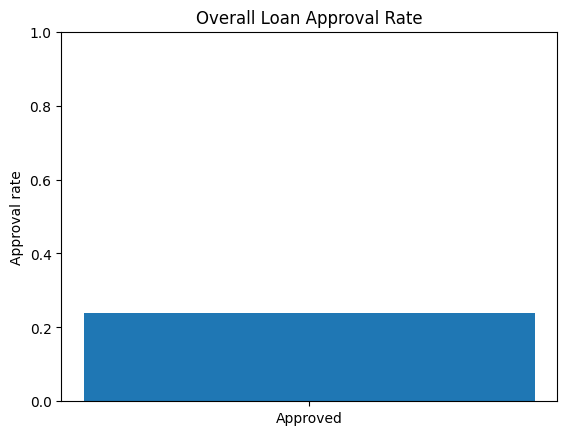

In [8]:
# 1) Overall approval rate
plt.figure()
plt.bar(["Approved"], [overall_approval])
plt.ylim(0, 1)
plt.title("Overall Loan Approval Rate")
plt.ylabel("Approval rate")
plt.show()

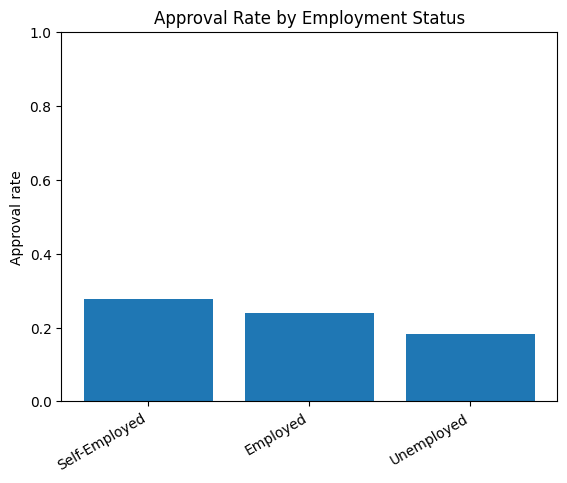

EmploymentStatus
Self-Employed    0.278449
Employed         0.240021
Unemployed       0.181884
Name: LoanApproved, dtype: float64

In [9]:
# 2) Approval rate by EmploymentStatus
rates = approval_rate_by("EmploymentStatus")
plt.figure()
plt.bar(rates.index, rates.values)
plt.ylim(0, 1)
plt.title("Approval Rate by Employment Status")
plt.ylabel("Approval rate")
plt.xticks(rotation=30, ha="right")
plt.show()

rates

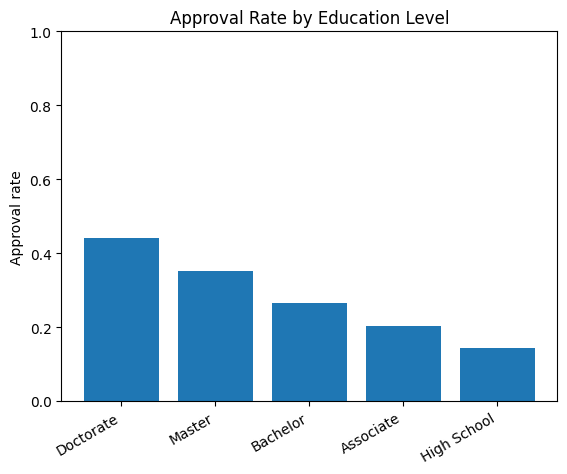

EducationLevel
Doctorate      0.440252
Master         0.350820
Bachelor       0.266435
Associate      0.204264
High School    0.144381
Name: LoanApproved, dtype: float64

In [10]:
# 3) Approval rate by EducationLevel
rates = approval_rate_by("EducationLevel")
plt.figure()
plt.bar(rates.index, rates.values)
plt.ylim(0, 1)
plt.title("Approval Rate by Education Level")
plt.ylabel("Approval rate")
plt.xticks(rotation=30, ha="right")
plt.show()

rates

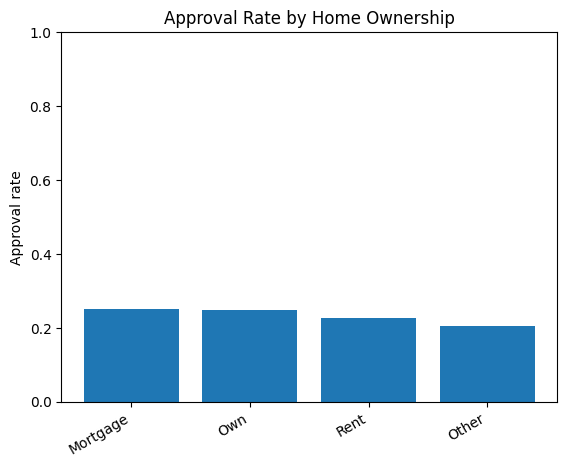

HomeOwnershipStatus
Mortgage    0.251543
Own         0.248857
Rent        0.227698
Other       0.204813
Name: LoanApproved, dtype: float64

In [11]:
# 4) Approval rate by HomeOwnershipStatus
rates = approval_rate_by("HomeOwnershipStatus")
plt.figure()
plt.bar(rates.index, rates.values)
plt.ylim(0, 1)
plt.title("Approval Rate by Home Ownership")
plt.ylabel("Approval rate")
plt.xticks(rotation=30, ha="right")
plt.show()

rates

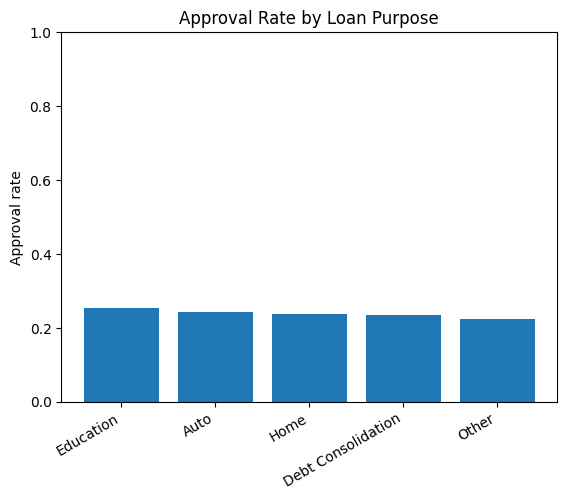

LoanPurpose
Education             0.252992
Auto                  0.242687
Home                  0.237975
Debt Consolidation    0.235130
Other                 0.223330
Name: LoanApproved, dtype: float64

In [12]:
# 5) Approval rate by LoanPurpose
rates = approval_rate_by("LoanPurpose")
plt.figure()
plt.bar(rates.index, rates.values)
plt.ylim(0, 1)
plt.title("Approval Rate by Loan Purpose")
plt.ylabel("Approval rate")
plt.xticks(rotation=30, ha="right")
plt.show()

rates

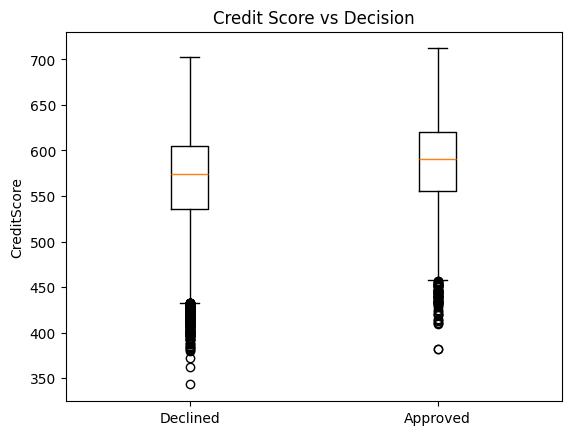

In [13]:
# 6) Credit Score distribution by approval decision (box plot)
approved = df[df["LoanApproved"] == 1]["CreditScore"]
declined = df[df["LoanApproved"] == 0]["CreditScore"]

plt.figure()
plt.boxplot([declined, approved], labels=["Declined", "Approved"])
plt.title("Credit Score vs Decision")
plt.ylabel("CreditScore")
plt.show()

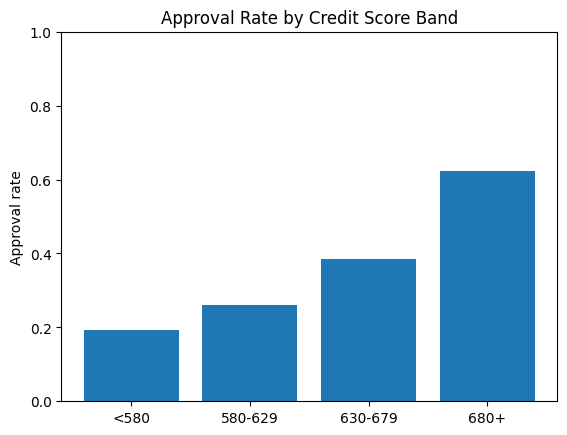

CreditScoreBin
<580       0.192519
580-629    0.261382
630-679    0.384044
680+       0.622642
Name: LoanApproved, dtype: float64

In [14]:
# 7) Approval rate by credit score band
cs = df.copy()
cs["CreditScoreBin"] = pd.cut(
    cs["CreditScore"],
    bins=[0, 580, 630, 680, 720],
    labels=["<580", "580-629", "630-679", "680+"]
)
cs_rates = cs.groupby("CreditScoreBin")["LoanApproved"].mean()

plt.figure()
plt.bar(cs_rates.index.astype(str), cs_rates.values)
plt.ylim(0, 1)
plt.title("Approval Rate by Credit Score Band")
plt.ylabel("Approval rate")
plt.show()

cs_rates

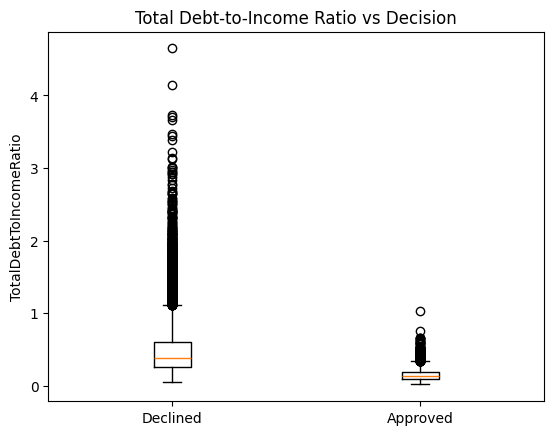

In [15]:
# 8) Total Debt-to-Income (DTI) vs decision (box plot)
approved = df[df["LoanApproved"] == 1]["TotalDebtToIncomeRatio"]
declined = df[df["LoanApproved"] == 0]["TotalDebtToIncomeRatio"]

plt.figure()
plt.boxplot([declined, approved], labels=["Declined", "Approved"])
plt.title("Total Debt-to-Income Ratio vs Decision")
plt.ylabel("TotalDebtToIncomeRatio")
plt.show()

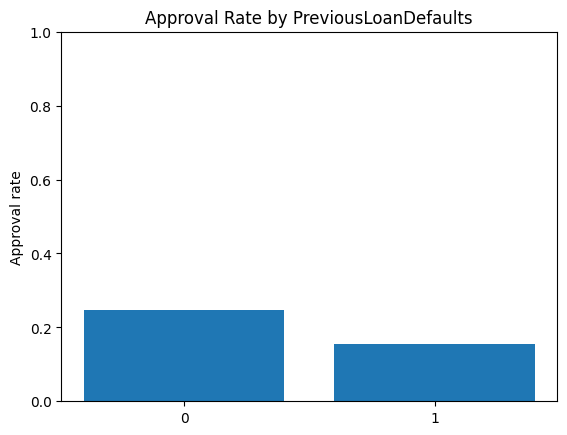

PreviousLoanDefaults
0    0.248292
1    0.155422
Name: LoanApproved, dtype: float64

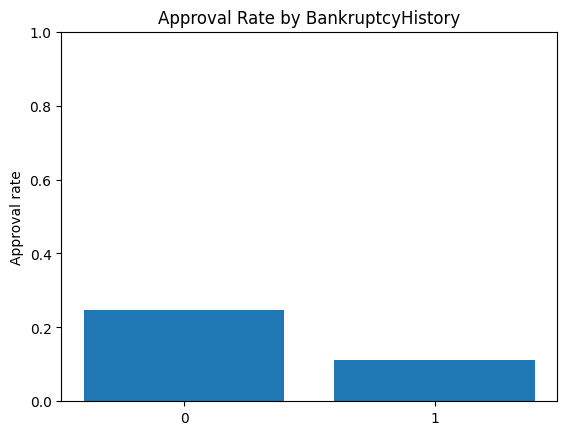

BankruptcyHistory
0    0.246095
1    0.110687
Name: LoanApproved, dtype: float64

In [16]:
# 9) Previous defaults + bankruptcy signals
for col in ["PreviousLoanDefaults", "BankruptcyHistory"]:
    rates = df.groupby(col)["LoanApproved"].mean()
    plt.figure()
    plt.bar(rates.index.astype(str), rates.values)
    plt.ylim(0, 1)
    plt.title(f"Approval Rate by {col}")
    plt.ylabel("Approval rate")
    plt.show()
    display(rates)

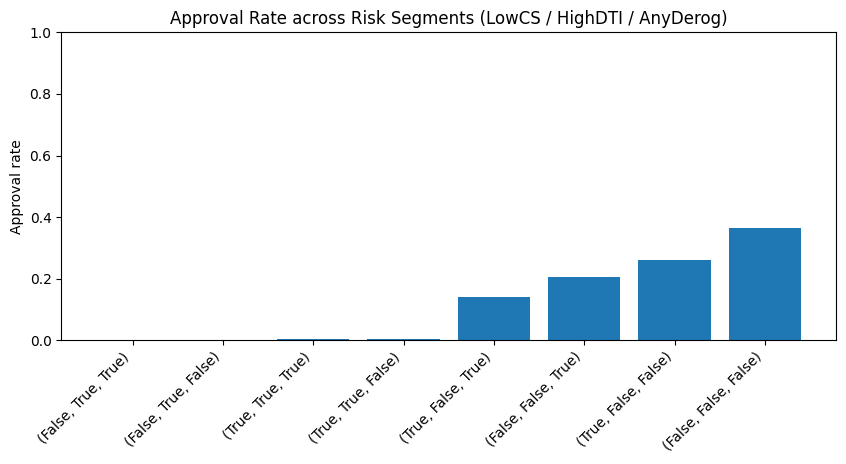

LowCS  HighDTI  AnyDerog
False  True     True        0.000000
                False       0.001515
True   True     True        0.003012
                False       0.003185
       False    True        0.142259
False  False    True        0.204132
True   False    False       0.262445
False  False    False       0.364512
Name: LoanApproved, dtype: float64

In [17]:
# 10) High-risk segmentation: low credit score + high total DTI + derogatory event
seg = df.copy()
seg["LowCS"] = seg["CreditScore"] < 580
seg["HighDTI"] = seg["TotalDebtToIncomeRatio"] > 0.6
seg["AnyDerog"] = (seg["PreviousLoanDefaults"] == 1) | (seg["BankruptcyHistory"] == 1)

seg_rates = seg.groupby(["LowCS", "HighDTI", "AnyDerog"])["LoanApproved"].mean().sort_values()

plt.figure(figsize=(10,4))
plt.bar(range(len(seg_rates)), seg_rates.values)
plt.title("Approval Rate across Risk Segments (LowCS / HighDTI / AnyDerog)")
plt.ylabel("Approval rate")
plt.xticks(range(len(seg_rates)), [str(i) for i in seg_rates.index], rotation=45, ha="right")
plt.ylim(0, 1)
plt.show()

seg_rates

### Business-memo insights (example wording)
1. **Baseline conversion:** Overall approval rate is ~24%, so this is a relatively conservative portfolio (high selectivity).
2. **Employment signal:** Unemployed applicants have materially lower approval rates than employed/self-employed groups.
3. **Education gradient:** Higher education levels correlate with higher approval rates (Doctorate/Master are strongest).
4. **Home ownership:** Mortgage/Own show slightly higher approvals than Rent/Other — consistent with lower perceived stability risk.
5. **Credit score matters:** Approval rate increases steadily with credit score; applicants in the 680+ band are approved at much higher rates.
6. **Debt burden matters:** Higher total DTI strongly correlates with declines; high DTI segments approach near-zero approval.
7. **Derogatory history:** Prior defaults and bankruptcy materially reduce approval likelihood (large drop vs clean history).

(We validate these narratives again with the model + interpretability.)

## 3) Modeling & Evaluation

**Minimum models:**
- KNN
- Decision Tree
- Random Forest (tree-based ensemble)

**Approach:**
- Train/test split (stratified)
- Cross-validation on training (2-fold to keep runtime reasonable here)
- Metrics: ROC-AUC, PR-AUC, Confusion Matrix, Classification Report

We build consistent `sklearn` pipelines:
- Numeric: median impute + standardize
- Categorical: most-frequent impute + one-hot encode

In [18]:
# Preprocessing pipeline
preprocess = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), num_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols),
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

models = {
    "KNN": KNeighborsClassifier(n_neighbors=35),
    "Decision Tree": DecisionTreeClassifier(max_depth=6, random_state=42, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(
        n_estimators=80, min_samples_leaf=5, random_state=42, n_jobs=1,
        class_weight="balanced_subsample"
    ),
    # Added for coefficient-based explainability (not required but useful)
    "Logistic Regression": LogisticRegression(max_iter=1000, n_jobs=1, class_weight="balanced"),
}

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
scoring = {"roc_auc":"roc_auc", "avg_precision":"average_precision"}

rows = []
pipes = {}

for name, clf in models.items():
    pipe = Pipeline([("preprocess", preprocess), ("model", clf)])
    pipes[name] = pipe
    cvres = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=1)
    rows.append({
        "Model": name,
        "CV ROC-AUC (mean)": cvres["test_roc_auc"].mean(),
        "CV PR-AUC (mean)": cvres["test_avg_precision"].mean(),
    })

cv_table = pd.DataFrame(rows).sort_values("CV ROC-AUC (mean)", ascending=False)
cv_table

,Model,CV ROC-AUC (mean),CV PR-AUC (mean)
3,Logistic Regression,0.999989,0.999968
2,Random Forest,0.998539,0.995485
0,KNN,0.994666,0.981803
1,Decision Tree,0.978465,0.956752


In [19]:
# Test-set evaluation at default threshold 0.50
test_rows = []
test_preds = {}

for name, pipe in pipes.items():
    pipe.fit(X_train, y_train)
    proba = pipe.predict_proba(X_test)[:, 1]
    pred = (proba >= 0.50).astype(int)
    test_rows.append({
        "Model": name,
        "Test ROC-AUC": roc_auc_score(y_test, proba),
        "Test PR-AUC": average_precision_score(y_test, proba),
    })
    test_preds[name] = (pipe, proba, pred)

pd.DataFrame(test_rows).sort_values("Test ROC-AUC", ascending=False)

,Model,Test ROC-AUC,Test PR-AUC
3,Logistic Regression,1.000000,1.000000
2,Random Forest,0.998947,0.996536
0,KNN,0.996373,0.987230
1,Decision Tree,0.993617,0.985737


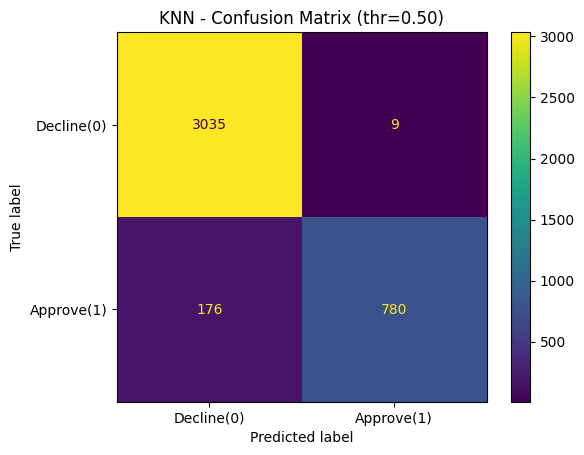

KNN
              precision    recall  f1-score   support

           0      0.945     0.997     0.970      3044
           1      0.989     0.816     0.894       956

    accuracy                          0.954      4000
   macro avg      0.967     0.906     0.932      4000
weighted avg      0.956     0.954     0.952      4000



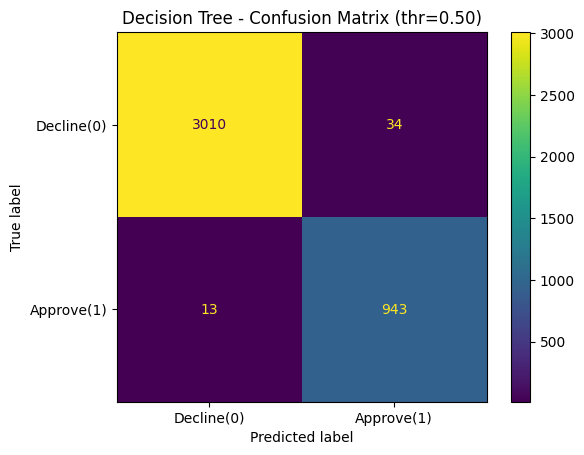

Decision Tree
              precision    recall  f1-score   support

           0      0.996     0.989     0.992      3044
           1      0.965     0.986     0.976       956

    accuracy                          0.988      4000
   macro avg      0.980     0.988     0.984      4000
weighted avg      0.988     0.988     0.988      4000



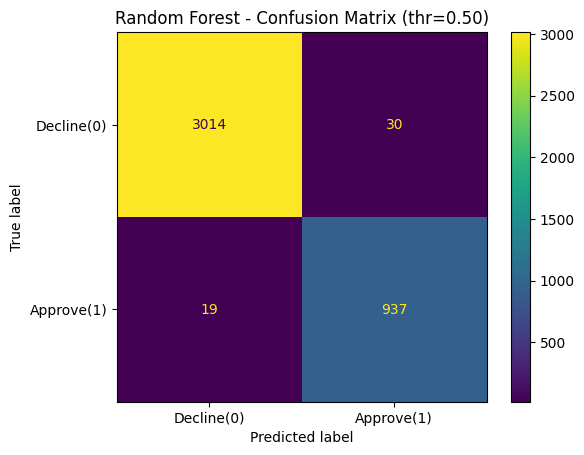

Random Forest
              precision    recall  f1-score   support

           0      0.994     0.990     0.992      3044
           1      0.969     0.980     0.975       956

    accuracy                          0.988      4000
   macro avg      0.981     0.985     0.983      4000
weighted avg      0.988     0.988     0.988      4000



In [20]:
# Confusion matrices (default threshold = 0.50)
for name in ["KNN", "Decision Tree", "Random Forest"]:
    pipe, proba, pred = test_preds[name]
    cm = confusion_matrix(y_test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Decline(0)", "Approve(1)"])
    disp.plot()
    plt.title(f"{name} - Confusion Matrix (thr=0.50)")
    plt.show()

    print(name)
    print(classification_report(y_test, pred, digits=3))

### Choosing the final model
A bank usually prefers:
- strong performance,
- stable behavior under distribution shift,
- explainability + controllable decision threshold,
- low operational complexity.

Here we choose **Random Forest** as the primary model:
- strong ranking performance (ROC-AUC / PR-AUC),
- robust nonlinear interactions,
- feature importance + partial dependence are available.

> Note: If you see *near-perfect* metrics, it can indicate **label leakage** (some features may encode the underwriting decision). In real work, we would audit features like `InterestRate`, `RiskScore`, or any post-decision fields and rebuild the model without them.

## Decision Rule: Approval/Decline Threshold (Business Risk)

We use a simple cost-sensitive rule:
- **False Approval (FP):** approving an application that historically was declined → higher credit loss risk  
- **False Decline (FN):** declining an application that historically was approved → opportunity cost

Example cost ratio:
- FP cost = 5
- FN cost = 1

We search thresholds on a validation split and choose the threshold that minimizes expected cost.

In [21]:
from sklearn.model_selection import train_test_split

# Validation split from training
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train
)

rf = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=120, min_samples_leaf=5, random_state=42, n_jobs=1,
        class_weight="balanced_subsample"
    ))
])

rf.fit(X_tr, y_tr)
val_proba = rf.predict_proba(X_val)[:, 1]

cost_fp, cost_fn = 5, 1
thresholds = np.linspace(0.01, 0.99, 99)

best = None
for thr in thresholds:
    pred = (val_proba >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val, pred).ravel()
    cost = cost_fp * fp + cost_fn * fn
    if best is None or cost < best["cost"]:
        best = {"threshold": thr, "cost": cost, "tn": tn, "fp": fp, "fn": fn, "tp": tp}

best

{'threshold': np.float64(0.67),
 'cost': np.int64(80),
 'tn': np.int64(3037),
 'fp': np.int64(7),
 'fn': np.int64(45),
 'tp': np.int64(911)}

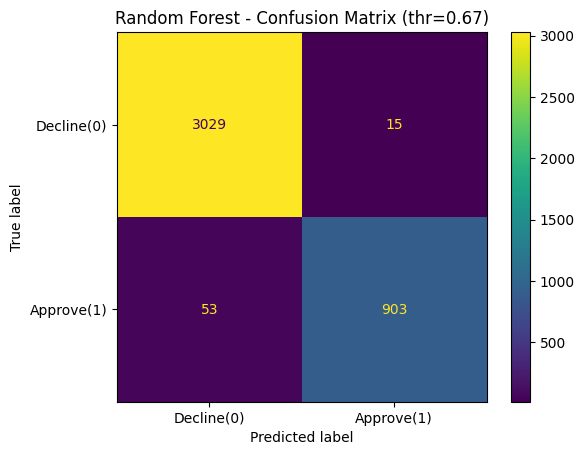

Threshold: 0.67
Precision: 0.9836601307189542
Recall: 0.944560669456067
F1: 0.9637139807897546


In [22]:
# Evaluate chosen threshold on the test set
rf_test_proba = test_preds["Random Forest"][1]
thr = best["threshold"]

rf_test_pred = (rf_test_proba >= thr).astype(int)

cm = confusion_matrix(y_test, rf_test_pred)
ConfusionMatrixDisplay(cm, display_labels=["Decline(0)", "Approve(1)"]).plot()
plt.title(f"Random Forest - Confusion Matrix (thr={thr:.2f})")
plt.show()

print("Threshold:", thr)
print("Precision:", precision_score(y_test, rf_test_pred))
print("Recall:", recall_score(y_test, rf_test_pred))
print("F1:", f1_score(y_test, rf_test_pred))

## 4) Model Interpretability

We provide:
- Ranked feature importance (Random Forest)
- Partial Dependence Plots (2–3 numeric drivers)
- Coefficient analysis (Logistic Regression baseline) — *useful for stakeholder explanations*

In [23]:
# Feature importance for Random Forest (handle one-hot feature names)
rf_pipe = test_preds["Random Forest"][0]

# Fit to full training set (already fit, but ensure)
rf_pipe.fit(X_train, y_train)

ohe = rf_pipe.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)

feature_names = np.concatenate([num_cols, cat_feature_names])

importances = rf_pipe.named_steps["model"].feature_importances_
fi = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False)

fi.head(15)

,feature,importance
28,RiskScore,0.447363
27,TotalDebtToIncomeRatio,0.125352
20,MonthlyIncome,0.119912
1,AnnualIncome,0.104915
25,InterestRate,0.036892
4,LoanAmount,0.025876
24,BaseInterestRate,0.018863
26,MonthlyLoanPayment,0.018320
18,TotalAssets,0.014580
23,NetWorth,0.014083


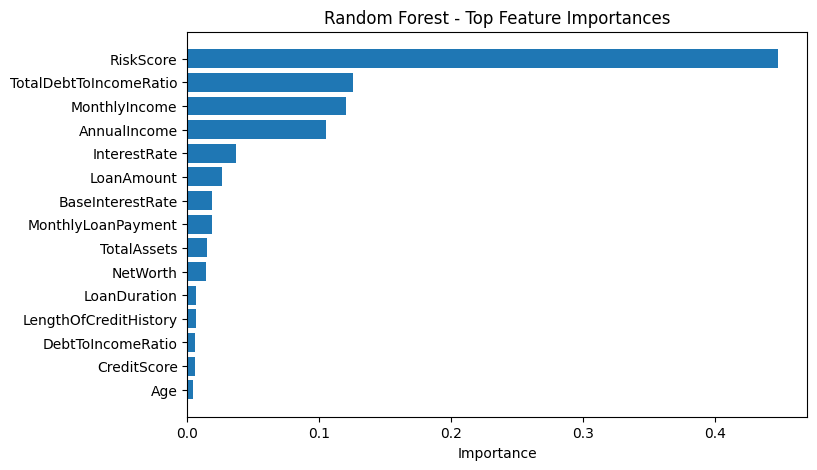

In [24]:
# Plot top 15 importances
top = fi.head(15)[::-1]
plt.figure(figsize=(8,5))
plt.barh(top["feature"], top["importance"])
plt.title("Random Forest - Top Feature Importances")
plt.xlabel("Importance")
plt.show()

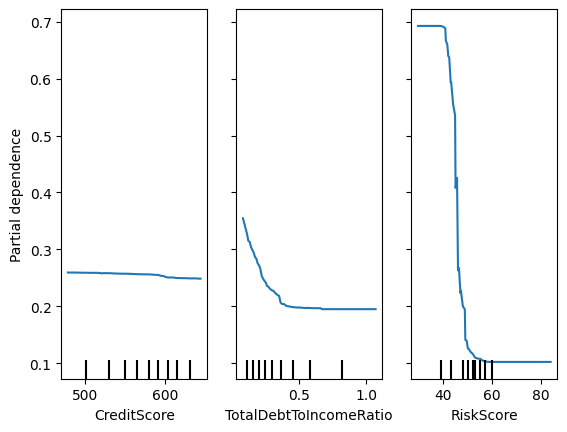

In [25]:
# Partial dependence plots for key numeric features
features_for_pdp = ["CreditScore", "TotalDebtToIncomeRatio", "RiskScore"]

PartialDependenceDisplay.from_estimator(
    rf_pipe, X_test, features_for_pdp, kind="average"
)
plt.show()

In [26]:
# Coefficient analysis (Logistic Regression)
lr_pipe = test_preds["Logistic Regression"][0]
lr_pipe.fit(X_train, y_train)

lr = lr_pipe.named_steps["model"]
coefs = lr.coef_.ravel()

ohe = lr_pipe.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([num_cols, cat_feature_names])

coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs}).sort_values("coef")

coef_df.tail(10), coef_df.head(10)

(                           feature      coef
 3                       Experience  0.199546
 37        EducationLevel_Doctorate  0.435231
 1                     AnnualIncome  0.629460
 33  EmploymentStatus_Self-Employed  0.656870
 24                BaseInterestRate  0.666541
 8        CreditCardUtilizationRate  0.811123
 13            PreviousLoanDefaults  1.384738
 12               BankruptcyHistory  1.668001
 20                   MonthlyIncome  1.745565
 11               DebtToIncomeRatio  2.713709,
                        feature      coef
 28                   RiskScore -9.147687
 25                InterestRate -2.389323
 32   EmploymentStatus_Employed -2.360579
 2                  CreditScore -1.889110
 27      TotalDebtToIncomeRatio -1.475531
 38  EducationLevel_High School -1.141600
 4                   LoanAmount -1.112546
 26          MonthlyLoanPayment -0.849416
 45   HomeOwnershipStatus_Other -0.700321
 47    HomeOwnershipStatus_Rent -0.674802)

### Plain-English interpretation examples
- **Credit score:** Higher scores increase approval probability.
- **Total debt-to-income:** Higher DTI decreases approval probability; the model penalizes high debt burden.
- **Risk score:** Higher risk score decreases approval probability (as expected).

When communicating to stakeholders, avoid technical jargon:
- “This model approves fewer high-debt borrowers at the same credit score, because historical outcomes show higher risk in that segment.”

## Fairness & Monitoring (Portfolio-ready checklist)

Minimum practical checks (non-sensitive proxies in this dataset):
- Compare approval rates and model error rates across:
  - `EmploymentStatus`
  - `EducationLevel`
  - `HomeOwnershipStatus`

In production, you’d also:
- track drift (feature + prediction drift),
- periodically re-train,
- monitor fairness metrics and policy compliance.

In [27]:
# Simple group performance slice: precision/recall by EmploymentStatus for the Random Forest decision rule
df_test = X_test.copy()
df_test["LoanApproved"] = y_test.values
df_test["pred"] = rf_test_pred
df_test["EmploymentStatus"] = df.loc[df_test.index, "EmploymentStatus"].values  # original categorical

group_rows = []
for g, sub in df_test.groupby("EmploymentStatus"):
    y_true = sub["LoanApproved"].values
    y_hat = sub["pred"].values
    group_rows.append({
        "EmploymentStatus": g,
        "count": len(sub),
        "approval_rate_actual": y_true.mean(),
        "precision": precision_score(y_true, y_hat, zero_division=0),
        "recall": recall_score(y_true, y_hat, zero_division=0),
    })

pd.DataFrame(group_rows).sort_values("count", ascending=False)

,EmploymentStatus,count,approval_rate_actual,precision,recall
0,Employed,3402,0.242210,0.981203,0.950243
1,Self-Employed,311,0.263666,1.000000,0.878049
2,Unemployed,287,0.174216,1.000000,0.960000
